In [1]:
import json
import matplotlib.pyplot as plt
import warnings
import scipy as sp
import numpy as np
import pandas as pd

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error,accuracy_score 
from sklearn.metrics import confusion_matrix as sk_cmatrix
# %matplotlib inline

np.random.seed(seed=2019)
warnings.filterwarnings('ignore')


In [2]:
aaa = pd.read_csv('Brexit_20190327_G04_traindata.csv')
aaa.head()

,Unnamed: 0,Member,Constituency,Party,Vote386,Vote387,Vote388,Vote389,Vote390,Vote391,Vote392,Vote393,Percentage
0,1,Diane Abbott,Hackney North and Stoke Newington,Lab,No,Aye,No Vote,Aye,Aye,No Vote,Aye,No,0.205
1,2,Debbie Abrahams,Oldham East and Saddleworth,Lab,No,No Vote,No,Aye,Aye,No Vote,Aye,No,0.599
2,3,Nigel Adams,Selby and Ainsty,Con,No Vote,No,No,No,No,No,No,Aye,0.577
3,5,Adam Afriyie,Windsor,Con,Aye,No,No,No,No,No,No,Aye,0.467
4,6,Peter Aldous,Waveney,Con,No,No,Aye,No,No,No,No,No,0.634


In [3]:
raw_train = pd.read_csv('Brexit_20190327_G04_traindata.csv').drop(['Member','Unnamed: 0','Constituency'], axis=1)
raw_train = raw_train.drop(['Percentage'], axis=1)

raw_train.loc[raw_train['Party'] == 'Con','Party'] = 1
raw_train.loc[raw_train['Party'] == 'Lab','Party'] = 2
raw_train.loc[raw_train['Party'] == 'Ind','Party'] = 3
raw_train.loc[raw_train['Party'] == 'SNP','Party'] = 4
raw_train.loc[raw_train['Party'] == 'LD','Party'] = 5
raw_train.loc[raw_train['Party'] == 'DUP','Party'] = 6
y_train = raw_train['Party']
X_train = raw_train.drop(['Party'], axis=1)
X_train.head()



raw_test = pd.read_csv('Brexit_20190327_G04_testdata.csv').drop(['Member','Unnamed: 0','Constituency'], axis=1)
raw_test = raw_test.drop(['Percentage'], axis=1)

raw_test.loc[raw_test['Party'] == 'Con','Party'] = 1
raw_test.loc[raw_test['Party'] == 'Lab','Party'] = 2
raw_test.loc[raw_test['Party'] == 'Ind','Party'] = 3
raw_test.loc[raw_test['Party'] == 'SNP','Party'] = 4
raw_test.loc[raw_test['Party'] == 'LD','Party'] = 5
raw_test.loc[raw_test['Party'] == 'DUP','Party'] = 6

y_test = raw_test['Party']
X_test = raw_test.drop(['Party'], axis=1)




In [4]:
from sklearn import preprocessing 
for f in X_train.columns: 
    if X_train[f].dtype=='object': 
#         print(f)
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(X_train[f].values)) 
        X_train[f] = lbl.transform(list(X_train[f].values))
        
for f in X_test.columns: 
    if X_test[f].dtype=='object':
#         print(f)
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(X_test[f].values)) 
        X_test[f] = lbl.transform(list(X_test[f].values))
y_test = pd.to_numeric(y_test)
y_train= pd.to_numeric(y_train)


In [5]:
X_train.head()

,Vote386,Vote387,Vote388,Vote389,Vote390,Vote391,Vote392,Vote393
0,1,0,2,0,0,2,0,1
1,1,2,1,0,0,2,0,1
2,2,1,1,1,1,1,1,0
3,0,1,1,1,1,1,1,0
4,1,1,0,1,1,1,1,1


In [6]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [1, 2, 3, 4, 5, 6])
        return -accuracy_score(y, preds)
    
    def fit(self, X, y):
        loss_partial = partial(self.loss, X = X, y = y)
        initial_coef = [1.5, 2.5, 3.5, 4.5, 5.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [1, 2, 3, 4, 5, 6])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

In [7]:
### XGB ### 
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,KFold

xgb_params = {
    'eval_metric': 'rmse',
    'seed': 2019,
    'eta': 0.0123,
#     'subsample': 0.8,
#     'colsample_bytree': 0.85,
    'tree_method': 'hist',
    'silent': 1,
}
import lightgbm as lgb

### LGBM ### 
lgb_params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
#           'max_depth': 9,
          'learning_rate': 0.004,
#           'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_samples': 150,
#           'min_child_weight': 0.02,
#           'lambda_l2': 0.0475,
#           'verbosity': -1,
          'data_random_seed': 17
}

### CV ###
def run_xlgb(params1, params2, X_train, X_test,y_train,y_test):
    n_splits = 10
    verbose_eval = 1000
    num_rounds = 10000
    early_stop = 20
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2019)

    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0], n_splits))
   
    i = 0

    for train_idx, valid_idx in kf.split(X_train, y_train):
#         print(train_idx)
        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]
        
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[valid_idx]

        d_train1 = xgb.DMatrix(data=X_tr, label=y_tr, feature_names=X_tr.columns)
        d_valid1 = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)

        watchlist1 = [(d_train1, 'train'), (d_valid1, 'valid')]
        print('training XGB:')
        model1 = xgb.train(dtrain=d_train1, num_boost_round=num_rounds, evals=watchlist1,early_stopping_rounds=early_stop, verbose_eval=verbose_eval, params=params1)

        valid_pred1 = model1.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model1.best_ntree_limit)
        test_pred1 = model1.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model1.best_ntree_limit)
        print('acc of xgb:')
        print(accuracy_score(y_test, np.round(test_pred1).astype(np.int8)))
        oof_train[valid_idx] = valid_pred1
        oof_test[:, i] = test_pred1

        ####################


#         d_train2 = lgb.Dataset(X_tr, label=y_tr)
#         d_valid2 = lgb.Dataset(X_val, label=y_val)
# #         lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
#         watchlist2 = [d_train2, d_valid2]
#         print('training LGB:')
                  
#         model2 = lgb.train(params2,
#                       train_set=d_train2,
#                       num_boost_round=num_rounds,
#                       valid_sets=watchlist2,
#                       verbose_eval=verbose_eval,
#                       early_stopping_rounds=early_stop)

#         valid_pred2 = model2.predict(X_val, num_iteration=model2.best_iteration)
#         test_pred2 = model2.predict(X_test, num_iteration=model2.best_iteration)

#         oof_train[valid_idx] = valid_pred2
#         oof_test[:, i] = test_pred2
#         print('acc of lgb:')
#         print(accuracy_score(y_test, test_pred2.astype(np.int8)))
        
        i += 1
    return oof_train, oof_test

oof_train, oof_test = run_xlgb(xgb_params,lgb_params, X_train, X_test,y_train,y_test)



training XGB:
[0]	train-rmse:1.63956	valid-rmse:1.55639
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
Stopping. Best iteration:
[341]	train-rmse:0.26041	valid-rmse:0.479816

acc of xgb:
0.9625668449197861
training XGB:
[0]	train-rmse:1.64115	valid-rmse:1.54087
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
Stopping. Best iteration:
[258]	train-rmse:0.298387	valid-rmse:0.215246

acc of xgb:
0.9572192513368984
training XGB:
[0]	train-rmse:1.6557	valid-rmse:1.39338
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
Stopping. Best iteration:
[109]	train-rmse:0.542286	valid-rmse:0.803853

acc of xgb:
0.8716577540106952
training XGB:
[0]	train-rmse:1.62171	valid-rmse:1.71515
Multiple eval metrics have been

In [8]:
import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import mean_squared_error,accuracy_score 
from sklearn.metrics import confusion_matrix as sk_cmatrix


optR = OptimizedRounder()
optR.fit(oof_train, y_train.values)
coefficients = optR.coefficients()
valid_pred = optR.predict(oof_train, coefficients)
acc_val = accuracy_score(y_train, valid_pred)
print(acc_val)


test_predictions = optR.predict(oof_test.mean(axis=1), coefficients).astype(np.int8)
acc_test = accuracy_score(y_test, test_predictions)
print(acc_test)


0.9327354260089686
0.9679144385026738


In [9]:
oof_test

array([[0.92166018, 0.97592664, 0.87276065, ..., 0.97856045, 0.97078919,
        0.95716131],
       [2.90470862, 2.85237455, 2.45893669, ..., 3.05564904, 2.83655787,
        2.09605408],
       [1.98013973, 1.94151413, 1.61660099, ..., 1.99972701, 1.99115634,
        1.81872523],
       ...,
       [2.00676012, 1.9180392 , 1.61911094, ..., 1.96752334, 1.95501208,
        1.8558557 ],
       [5.85941124, 5.63396311, 4.32727146, ..., 5.9975028 , 5.92444468,
        5.10205936],
       [2.95478344, 2.91311336, 2.45893669, ..., 3.09864855, 3.03478813,
        2.71151567]])

In [10]:
y_test.values

array([1, 3, 2, 1, 1, 4, 2, 4, 1, 1, 1, 1, 1, 4, 1, 1, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 5, 2, 1, 1, 2, 1, 4, 2, 2, 2, 1,
       1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 3, 2, 1, 2, 4, 1, 1, 1, 6, 2, 4,
       1, 1, 4, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1,
       4, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1,
       2, 4, 5, 2, 1, 2, 2, 1, 1, 3, 1, 6, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1,
       2, 2, 2, 2, 1, 1, 1, 4, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 5, 2, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 3, 6, 3])

In [11]:
test_predictions

array([1, 3, 2, 1, 1, 4, 2, 4, 1, 1, 1, 1, 1, 4, 1, 1, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 5, 2, 1, 1, 2, 1, 4, 2, 2, 2, 1,
       1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 3, 2, 1, 2, 4, 1, 1, 1, 6, 2, 1,
       1, 1, 4, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 3, 1, 3, 2, 1,
       4, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 3, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1,
       2, 4, 5, 2, 1, 2, 2, 1, 1, 1, 1, 6, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1,
       2, 2, 2, 2, 1, 1, 1, 4, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 5, 2, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 2, 6, 3], dtype=int8)

In [12]:
print(f'test pred distribution: {Counter(test_predictions)}')

test pred distribution: Counter({1: 93, 2: 73, 4: 9, 3: 6, 5: 3, 6: 3})


In [51]:
# plt.hist([test_predictions,y_test],10)
# plt.legend(['Prediction','True value'])
# plt.savefig('aim1')

In [15]:
ax.set_xticklabels(['Con','Lab','Ind','SNP','LD','DUP']
# index_ls = ['Con','Lab','Ind','SNP','LD','DUP']
plt.hist([test_predictions,y_test],10)


SyntaxError: invalid syntax (<ipython-input-15-78540068cf49>, line 3)

In [7]:
### XGB ### 
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,KFold

xgb_params = {
    'eval_metric': 'rmse',
    'seed': 2019,
    'eta': 0.0123,
#     'subsample': 0.8,
#     'colsample_bytree': 0.85,
    'tree_method': 'hist',
    'silent': 1,
}

xgb_train = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
xgb_test = xgb.DMatrix(data=X_test, label=y_test, feature_names=X_test.columns)

watchlist1 = [(xgb_train, 'train'), (xgb_test, 'test')]
model_xgb = xgb.train(dtrain=xgb_train, num_boost_round=10000, evals=watchlist1,early_stopping_rounds=20, verbose_eval=100, params=xgb_params)

# valid_pred1 = model1.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model1.best_ntree_limit)
test_pred_xgb = model_xgb.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model_xgb.best_ntree_limit)
print('acc of xgb:')
print(accuracy_score(y_test, np.round(test_pred_xgb).astype(np.int8)))



[0]	train-rmse:1.63117	test-rmse:1.61136
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[100]	train-rmse:0.586613	test-rmse:0.581323
[200]	train-rmse:0.324359	test-rmse:0.359579
[300]	train-rmse:0.277049	test-rmse:0.337989
Stopping. Best iteration:
[299]	train-rmse:0.277226	test-rmse:0.337972

acc of xgb:
0.9679144385026738


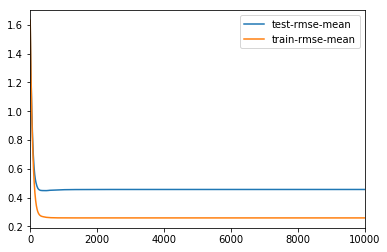

In [10]:
zkn =xgb.cv(xgb_params, xgb_train, num_boost_round=10000, nfold=10, stratified=False, folds=None, metrics=('rmse'), obj=None, feval=None, maximize=False, early_stopping_rounds=20, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=2019, callbacks=None, shuffle=True)
zkn.loc[0:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.savefig('aim1_rmse')



In [27]:
xgb.cv(xgb_params, dtrain=xgb_train, num_boost_round=10, nfold=10, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)



,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.631089,0.023417,1.619191,0.205858
1,1.613063,0.023099,1.601455,0.204556
2,1.595256,0.022786,1.583955,0.203280
3,1.577663,0.022476,1.566677,0.202026
4,1.560285,0.022170,1.549618,0.200804
5,1.543118,0.021868,1.532927,0.199511
6,1.526160,0.021570,1.516447,0.198247
7,1.509407,0.021277,1.500304,0.196926
8,1.492859,0.020985,1.484136,0.195806
9,1.476511,0.020697,1.468424,0.194549


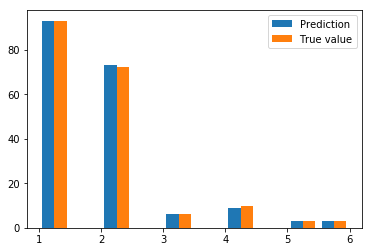

In [50]:

plt.hist([np.round(test_pred_xgb),y_test],10)
plt.legend(['Prediction','True value'])
plt.savefig('aim1')

In [40]:
# d_train1 = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)

# watchlist1 = [(d_train1, 'train')]
# model1 = xgb.train(dtrain=d_train1, num_boost_round=10000, evals=watchlist1,early_stopping_rounds=20, verbose_eval=100, params=xgb_params)

# # valid_pred1 = model1.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model1.best_ntree_limit)
# test_pred1 = model1.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model1.best_ntree_limit)
# #         print('acc of xgb:')
# print(accuracy_score(y_test, np.round(test_pred1).astype(np.int8)))

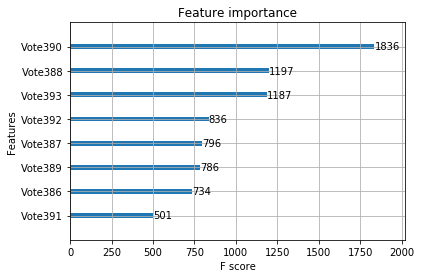

In [43]:
xgb.plot_importance(model_xgb, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=None, grid=True, show_values=True)

plt.savefig('xgb_tree.jpg')

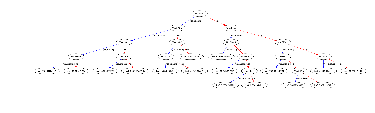

In [44]:
xgb.plot_tree(model_xgb)

In [45]:
digraph = xgb.to_graphviz(model_xgb, num_trees=1)
digraph.format = 'png'
digraph.view('iris_xgb')

'iris_xgb.png'

In [52]:
xgb.cv(xgb_params, xgb_train, num_boost_round=10000, nfold=10, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=20, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=2019, callbacks=None, shuffle=True)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.631084,0.024941,1.617976,0.225307
1,1.613060,0.024624,1.600468,0.223703
2,1.595256,0.024311,1.583191,0.222122
3,1.577667,0.024001,1.566126,0.220568
4,1.560292,0.023697,1.549279,0.219022
5,1.543124,0.023393,1.532740,0.217479
6,1.526169,0.023097,1.516405,0.215965
7,1.509416,0.022799,1.500296,0.214490
8,1.492867,0.022508,1.484326,0.213041
9,1.476524,0.022223,1.468647,0.211602


In [8]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

lgb_params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
#           'max_depth': 9,
          'learning_rate': 0.004,
#           'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_samples': 150,
#           'min_child_weight': 0.02,
#           'lambda_l2': 0.0475,
#           'verbosity': -1,
          'data_random_seed': 17
    
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

evals_result = {}
gbm = lgb.train(lgb_params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train, lgb_test],
                evals_result=evals_result,
                verbose_eval=100,
                early_stopping_rounds=20)
test_pred_lgbm = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print(accuracy_score(y_test, np.round(test_pred_lgbm).astype(np.int8)))

Training until validation scores don't improve for 20 rounds.
[100]	training's rmse: 0.876181	valid_1's rmse: 0.847624
[200]	training's rmse: 0.774608	valid_1's rmse: 0.730307
[300]	training's rmse: 0.677213	valid_1's rmse: 0.641642
[400]	training's rmse: 0.602654	valid_1's rmse: 0.585909
[500]	training's rmse: 0.561509	valid_1's rmse: 0.560887
[600]	training's rmse: 0.540663	valid_1's rmse: 0.547356
[700]	training's rmse: 0.527598	valid_1's rmse: 0.536368
[800]	training's rmse: 0.518096	valid_1's rmse: 0.528435
[900]	training's rmse: 0.509978	valid_1's rmse: 0.521631
[1000]	training's rmse: 0.502415	valid_1's rmse: 0.515137
[1100]	training's rmse: 0.494537	valid_1's rmse: 0.508804
[1200]	training's rmse: 0.487439	valid_1's rmse: 0.503429
[1300]	training's rmse: 0.479716	valid_1's rmse: 0.498883
[1400]	training's rmse: 0.472911	valid_1's rmse: 0.494954
[1500]	training's rmse: 0.467056	valid_1's rmse: 0.491644
[1600]	training's rmse: 0.461693	valid_1's rmse: 0.488668
[1700]	training's r

In [ ]:
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

In [ ]:
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

In [ ]:
ax = lgb.plot_tree(gbm, tree_index=3, figsize=(20, 8), show_info=['split_gain'])
plt.show()

In [ ]:
graph = lgb.create_tree_digraph(gbm, tree_index=3, name='Tree3')
graph.render(view=True)